<a href="https://colab.research.google.com/github/raheelam98/LangGraph/blob/main/agent_work/RapidContent_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rapid Content

In [ ]:
%%capture --no-stderr
!pip install --quiet -U langgraph langgraph_sdk langgraph-checkpoint-sqlite langchain-google-genai langchain-experimental  langchain_core langchain_community
!apt-get install --quiet graphviz libgraphviz-dev pkg-config
!pip install --quiet -U pygraphviz
%pip install --quiet -U wikipedia tavily-python

# !pip install --quiet -U gradio

In [ ]:
import operator
import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain_core.pydantic_v1 import BaseModel
class Queries(BaseModel):
    queries: List[str]

class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')
# print('GOOGLE_API_KEY: ', GOOGLE_API_KEY)

from langchain_google_genai import ChatGoogleGenerativeAI
MODEL_NAME = "gemini-1.5-flash"
model = ChatGoogleGenerativeAI(
    model=MODEL_NAME,
    generation_config={"response_mime_type": "application/json",
    "response_schema": list[AgentState]},
    temperature=0.1,
    api_key = GOOGLE_API_KEY,
    )

from tavily import TavilyClient
tavily = TavilyClient(userdata.get('Tavily_API_Key'))
# print('TAVILY_API_KEY: ',tavily.api_key)

1. Choose a Clear Topic and Define Your Audience
Audience Identification: Know who will benefit from the content and what tone to use.
Topic Relevance: Pick a topic that interests your audience and is relevant to your niche.
2. Research Thoroughly
Gather Data: Find reliable sources, statistics, and insights.
Identify Gaps: See what existing posts miss and how you can add value.
3. Craft a Compelling Title
Make it Engaging: A strong title should be informative yet intriguing.
Use Keywords: Include keywords naturally for SEO.
4. Outline Your Content
Organize Structure: Use headings and subheadings for a logical flow.
Key Points: List key points under each section to stay focused.
5. Write an Engaging Introduction
Hook the Reader: Start with a question, a fact, or a story.
Preview the Content: Let readers know what they'll learn.
6. Develop the Body
Clear Subheadings: Each section should address one point.
Use Examples: Real-life examples or case studies make it relatable.
Keep it Scannable: Short paragraphs, bullet points, and visuals help readability.
7. Incorporate Visuals and Media
Use Relevant Images: Diagrams, infographics, or videos to support points.
Alt Text: Optimize images with descriptive alt text for accessibility.
8. Write a Strong Conclusion
Summarize Key Points: Recap the main takeaways.
Call-to-Action (CTA): Encourage readers to comment, share, or subscribe.
9. Edit and Proofread
Check Grammar and Flow: Edit for clarity and eliminate errors.
Get Feedback: A second opinion can spot things you missed.
10. Optimize for SEO
Keywords: Ensure keywords are in the title, headers, and meta description.
Meta Description: Write a short, enticing summary of the post.
11. Publish and Promote
Social Media: Share the post across platforms.
Engage with Readers: Respond to comments or questions.


In [ ]:
# You are an expert ________. Your goal is to ______
PLANNER_PROMPT = """You are an expert blogger and SEO expert. Your goal is to write a high level outline of a blog. \
Write such an outline for the user provided topic. Give an outline of the blog along with any relevant SEO tips\
and instructions for the sections. Also suggest how long should be each section and how long should the blog be."""

In [ ]:
# RESEARCH_PLAN_PROMPT = """You are a research assistant charged with providing information that can \
# be used when writing the following blog. Generate a list of search queries that will gather \
# any relevant information. Only generate 3 queries max."""

RESEARCHER_PROMPT = """You are an expert research assistant tasked with gathering relevant information for a blog post. \
You will focus on generating research that will help in writing SEO optimized article.
Please generate a maximum of three focused search queries that will yield valuable insights and data for the topic at hand.
"""

In [ ]:
WRITER_PROMPT = """You are an expert blogger tasked with writing an excellent blog.\
Generate the best and most SEO optimized blog possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed:

------

{content}"""

In [ ]:
EDITOR_PROMPT = """You are an experienced editor of a blogging platform grading a blog submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [ ]:
ARTIST_PROMPT = """You are an expert artist. Your goal is to search and return artwork most related to the blog post. \
Generate a list of search queries that will gather any relevant imagery. Only generate 2 queries max."""


In [ ]:
def planner_node(state: AgentState):
    messages = [
        SystemMessage(content=PLANNER_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [ ]:
def researcher_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCHER_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state.get('content', [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=3)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [ ]:
def writer_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 0) + 1
    }

In [ ]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=EDITOR_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [ ]:
def artist_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=ARTIST_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [ ]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        print("Reached max revisions")
        return "artist"
    print("Should continue")
    return "editor"

In [ ]:
builder = StateGraph(AgentState)

builder.add_node("planner", planner_node)
builder.add_node("researcher", researcher_node)
builder.add_node("writer", writer_node)
builder.add_node("editor", reflection_node)
builder.add_node("artist", artist_node)

In [ ]:
builder.set_entry_point("planner")

builder.add_edge("planner", "researcher")
builder.add_edge("researcher", "writer")
builder.add_conditional_edges(
    "writer",
    should_continue,
    {"editor": "editor", "artist": "artist"}
)
builder.add_edge("editor", "writer")
builder.add_edge("artist",  END)



# builder.add_edge("writer", "editor")
# builder.add_conditional_edges(
#     "editor",
#     should_continue,
#     {"artist": "artist", "writer": "writer"}
# )

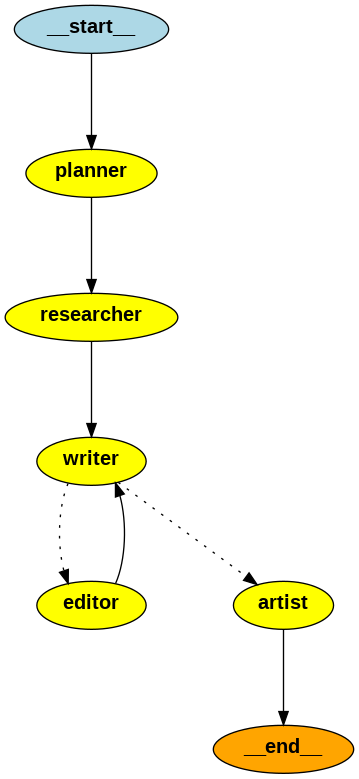

In [ ]:
from IPython.display import Image, display, Markdown
# memory = SqliteSaver.from_conn_string(":memory:")
with SqliteSaver.from_conn_string(":memory:") as checkpointer:
  graph = builder.compile(checkpointer=checkpointer)
Image(graph.get_graph().draw_png())

In [ ]:
with SqliteSaver.from_conn_string(":memory:") as checkpointer:
  graph = builder.compile(checkpointer=checkpointer)
  thread = {"configurable": {"thread_id": "1"}}

  for s in graph.stream({
    'task': "Write a blog describing, Navigating the Transition: Challenges and Solutions for Upgrading to Next.js 15",
    "max_revisions": 2,
    "revision_number": 0,
  }, thread):
    # print(f"\n\nNew output starting here: \n{s}")
    # print(f"Type of s: {type(s)}")
    markdown_content = ""
    for key, value in s.items():
      markdown_content += f"\n### {key}\n"  # Print key as a heading
      if isinstance(value, dict):
        for sub_key, sub_value in value.items():
            markdown_content += f"- **{sub_key}**: {sub_value}\n"  # Print sub-keys and values
      else:
        markdown_content += f"- {value}\n"  # Print value directly if not a dict

      # Display the Markdown content
      display(Markdown(markdown_content))


### planner
- **plan**: ## Blog Outline: Navigating the Transition: Challenges and Solutions for Upgrading to Next.js 15

**Target Audience:** Developers familiar with Next.js, looking to upgrade to version 15.

**Keywords:** Next.js, upgrade, version 15, challenges, solutions, migration, best practices, performance, features, app directory, server components, React Server Components,  

**Blog Length:** 1500-2000 words

**Sections:**

**1. Introduction (200 words)**

* **Hook:** Start with a compelling statement about the benefits of Next.js 15, highlighting its performance improvements and new features.
* **Problem:** Briefly describe the challenges developers face when upgrading to a new major version of a framework.
* **Solution:** Introduce the purpose of the blog - to guide developers through the upgrade process, addressing common challenges and providing solutions.
* **SEO:** Include relevant keywords in the introduction, especially "Next.js 15 upgrade" and "challenges."

**2. Key Features and Changes in Next.js 15 (300 words)**

* **App Directory:** Explain the new App Directory and its advantages over the Pages directory.
* **Server Components:** Discuss the introduction of Server Components and their impact on performance and code structure.
* **React Server Components:** Briefly mention the integration of React Server Components and their role in server-side rendering.
* **Other Notable Changes:** Highlight other significant changes like improved routing, data fetching, and built-in styling solutions.
* **SEO:** Use headings (H2, H3) for each feature, and include keywords like "App Directory," "Server Components," and "React Server Components."

**3. Challenges of Upgrading to Next.js 15 (400 words)**

* **Breaking Changes:** Discuss the most significant breaking changes in Next.js 15, including changes to routing, data fetching, and component structure.
* **Compatibility Issues:** Highlight potential compatibility issues with existing libraries and dependencies.
* **Learning Curve:** Acknowledge the learning curve associated with understanding and implementing new features like Server Components.
* **Migration Process:** Briefly outline the steps involved in migrating an existing Next.js application to version 15.
* **SEO:** Use headings (H2, H3) for each challenge, and include keywords like "breaking changes," "compatibility issues," and "migration process."

**4. Solutions and Best Practices (500 words)**

* **Official Migration Guide:** Recommend using the official Next.js migration guide as a starting point.
* **Code Modernization:** Provide tips on modernizing existing code to leverage new features like Server Components and the App Directory.
* **Dependency Management:** Discuss strategies for managing dependencies and ensuring compatibility with Next.js 15.
* **Testing and Debugging:** Emphasize the importance of thorough testing and debugging during the upgrade process.
* **Community Resources:** Encourage readers to utilize community resources like forums and Stack Overflow for support.
* **SEO:** Use headings (H2, H3) for each solution, and include keywords like "migration guide," "code modernization," and "dependency management."

**5. Conclusion (100 words)**

* **Recap:** Summarize the key challenges and solutions discussed in the blog.
* **Call to Action:** Encourage readers to start their upgrade journey and explore the benefits of Next.js 15.
* **SEO:** Include a strong call to action and reiterate the main keywords.

**6. Resources and Links (100 words)**

* **Official Next.js Documentation:** Link to the official Next.js documentation for version 15.
* **Migration Guide:** Link to the official Next.js migration guide.
* **Community Forums:** Link to relevant community forums and resources.
* **SEO:** Use anchor text that includes relevant keywords for each link.

**SEO Tips:**

* **Optimize Title Tag and Meta Description:** Use relevant keywords and a compelling description to attract readers.
* **Internal Linking:** Link to other relevant blog posts or resources on your website.
* **Image Optimization:** Use high-quality images with descriptive alt text.
* **Structured Data:** Implement schema markup to help search engines understand the content of your blog.
* **Social Media Sharing:** Encourage sharing on social media platforms.

**Note:** This outline provides a general structure. You can adjust the length of each section based on the depth of your content and the specific challenges and solutions you want to cover. Remember to write in a clear, concise, and engaging style, using relevant examples and code snippets to illustrate your points. 



{'name': 'Queries', 'parameters': {'type_': 6, 'properties': {'queries': {'type_': 5, 'items': {'type_': 1, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['queries'], 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}, 'description': ''}



### researcher
- **content**: ['4 days ago · Upgrading to Next.js 15, especially alongside React 19, is indeed a complex venture filled with numerous challenges. However, through careful', '4 days ago · I upgraded to Next.js 15, a bunch of dependency issues. I had a few problems with ESLint as well but I decided to simply use a legacy\xa0...What issues have you ran into upgrading to Next 15? : r/nextjsWorth upgrading to NextJS v15?Next.js 15 and Turbopack Dev (Stable) : r/nextjsNext.js 15 RC 2 : r/nextjsMore results from www.reddit.comMissing:  challenges | Show results with:challenges', 'This continuation highlights the key updates and enhancements introduced in Next.js 15, aimed at improving development workflows, boosting performance, and addressing important changes. With features like automated upgrades using the new codemod CLI, significant Turbopack optimizations, and enhanced security for Server Actions, Next.js 15 offers a wide range of tools to streamline processes. Codemods (automated code transformations) are included with every major Next.js release to help streamline the upgrade process for breaking changes. During development, Next.js now displays a Static Route Indicator to highlight whether routes are static or dynamic, helping with performance optimization. Next.js 15 continues to enhance developer experience with new features like the <Form> component, TypeScript support for next.config.ts, and the stable release of instrumentation.js.', 'Jun 6, 2024 · How to Migrate Your Next.js 14 Project To Next.js 15 · Step 1: Clone Starter Project · Step 2: Create a New Branch · Step 3: Start Migration.', 'Building Your Application: Upgrading | Next.js CSS-in-JS error.js loading.js mdx-components.js not-found.js page.js route.js CSS-in-JS Upgrade your application to newer versions of Next.js or migrate from the Pages Router to the App Router. ### Codemods Use codemods to upgrade your Next.js codebase when new features are released.### Version 15 Upgrade your Next.js Application from Version 14 to 15.### Version 14 Upgrade your Next.js Application from Version 13 to 14.### App Router Migration Learn how to upgrade your existing Next.js application from the Pages Router to the App Router.### Migrating from Create React App Learn how to migrate your existing React application from Create React App to Next.js.### Migrating from Vite Learn how to migrate your existing React application from Vite to Next.js.', "Upgrading: Version 15 | Next.js CSS-in-JS default.js error.js instrumentation.js layout.js loading.js mdx-components.js middleware.js not-found.js page.js route.js next.config.js Options CSS-in-JS next.config.js Options This won't be necessary once both Next.js 15 and React 19 are stable. app/layout.js To opt all fetch requests in a layout or page into caching, you can use the export const fetchCache = 'default-cache' segment config option. app/layout.js GET functions in Route Handlers are no longer cached by default. To opt GET methods into caching, you can use a route config option such as export const dynamic = 'force-static' in your Route Handler file. app/api/route.js When navigating between pages via <Link> or useRouter, page segments are no longer reused from the client-side router cache. next.config.js app/layout.js next.config.js next.config.js", "Next.js 15 Breaking Changes Special thanks to Łukasz Gajownik for helping out with this blog post. Next.js is the most popular full-stack React framework out there, and it's getting its fifteenth major update. While it won't be as revolutionary as the previous one, which introduced React Server Components among others."]


Should continue



### writer
- **draft**: ## Navigating the Transition: Challenges and Solutions for Upgrading to Next.js 15

**Introduction**

Next.js 15 is here, bringing a wave of exciting new features and performance enhancements that promise to revolutionize the way we build web applications. From the introduction of the App Directory and Server Components to the integration of React Server Components, Next.js 15 offers a powerful toolkit for creating faster, more efficient, and scalable applications. However, upgrading to a new major version of any framework can be a daunting task, especially when dealing with breaking changes and potential compatibility issues. This blog post aims to guide developers through the upgrade process, addressing common challenges and providing solutions to ensure a smooth transition to Next.js 15.

**Key Features and Changes in Next.js 15**

Next.js 15 introduces several significant changes that aim to improve developer experience, performance, and scalability. Here are some of the key features and changes:

### App Directory

The App Directory is a new file structure that replaces the traditional Pages directory. It offers a more streamlined and efficient way to organize and manage your application's routes and components. The App Directory leverages the power of Server Components and React Server Components, enabling faster rendering and improved data fetching capabilities.

### Server Components

Server Components are a new type of component that runs entirely on the server. This allows for faster rendering and reduced client-side JavaScript, leading to improved performance and user experience. Server Components also simplify data fetching and logic, making your code more maintainable and scalable.

### React Server Components

Next.js 15 integrates React Server Components, a powerful feature introduced in React 18. React Server Components allow you to render components on the server, reducing the amount of JavaScript sent to the client and improving initial page load times.

### Other Notable Changes

In addition to the App Directory, Server Components, and React Server Components, Next.js 15 also includes several other notable changes, such as:

* **Improved Routing:** The new routing system in Next.js 15 is more flexible and efficient, making it easier to manage complex applications.
* **Enhanced Data Fetching:** Next.js 15 provides improved data fetching capabilities, making it easier to fetch data from APIs and databases.
* **Built-in Styling Solutions:** Next.js 15 includes built-in styling solutions like CSS Modules and styled-jsx, making it easier to manage styles in your application.

**Challenges of Upgrading to Next.js 15**

While Next.js 15 offers numerous benefits, upgrading from previous versions can present several challenges:

### Breaking Changes

Next.js 15 introduces significant breaking changes, particularly in the way routing, data fetching, and component structure are handled. These changes require developers to adapt their existing code to work with the new features and functionalities.

### Compatibility Issues

Upgrading to Next.js 15 may lead to compatibility issues with existing libraries and dependencies. Some libraries may not be compatible with the new version of Next.js, requiring updates or replacements.

### Learning Curve

The introduction of new features like Server Components and the App Directory requires developers to invest time in learning and understanding these concepts. This learning curve can be a challenge for developers who are new to these features.

### Migration Process

Migrating an existing Next.js application to version 15 can be a complex process, requiring careful planning and execution. Developers need to consider the impact of breaking changes, compatibility issues, and the need to update their codebase.

**Solutions and Best Practices**

To navigate the challenges of upgrading to Next.js 15, developers can follow these solutions and best practices:

### Official Migration Guide

The official Next.js migration guide provides a comprehensive roadmap for upgrading your application. It outlines the steps involved in migrating from previous versions, including codemods for automated code transformations.

### Code Modernization

Modernizing your existing code to leverage the new features of Next.js 15 is crucial. This includes adopting the App Directory, implementing Server Components, and utilizing React Server Components where appropriate.

### Dependency Management

Managing dependencies is essential for ensuring compatibility with Next.js 15. Regularly update your dependencies to the latest versions and check for compatibility issues with the new version of Next.js.

### Testing and Debugging

Thorough testing and debugging are essential during the upgrade process. Test your application thoroughly after each step of the migration to identify and resolve any issues early on.

### Community Resources

Leverage the Next.js community for support and guidance. Forums like Reddit's r/nextjs and Stack Overflow are valuable resources for finding solutions to common problems and getting help from experienced developers.

**Conclusion**

Upgrading to Next.js 15 can be a challenging but rewarding experience. By understanding the key features and changes, addressing potential challenges, and following best practices, developers can successfully migrate their applications and unlock the full potential of Next.js 15. Embrace the new features, leverage the power of Server Components and React Server Components, and enjoy the performance and scalability benefits that Next.js 15 offers.

**Resources and Links**

* **Official Next.js Documentation:** [https://nextjs.org/docs](https://nextjs.org/docs)
* **Migration Guide:** [https://nextjs.org/docs/app/building-your-application/upgrading](https://nextjs.org/docs/app/building-your-application/upgrading)
* **Next.js Community Forum:** [https://www.reddit.com/r/nextjs/](https://www.reddit.com/r/nextjs/)
* **Stack Overflow:** [https://stackoverflow.com/questions/tagged/next.js](https://stackoverflow.com/questions/tagged/next.js)

**SEO Tips:**

* **Title Tag:** Next.js 15 Upgrade: Challenges and Solutions for Developers
* **Meta Description:** A comprehensive guide to upgrading your Next.js application to version 15, addressing common challenges and providing solutions for a smooth transition.
* **Internal Linking:** Link to other relevant blog posts on your website, such as articles about Server Components, React Server Components, or the App Directory.
* **Image Optimization:** Use high-quality images with descriptive alt text related to Next.js 15 features.
* **Structured Data:** Implement schema markup to help search engines understand the content of your blog.
* **Social Media Sharing:** Encourage sharing on social media platforms with relevant hashtags like #NextJS, #NextJS15, #WebDev. 

- **revision_number**: 1



### editor
- **critique**: ## Critique and Recommendations for "Navigating the Transition: Challenges and Solutions for Upgrading to Next.js 15"

This blog post provides a good overview of the challenges and solutions for upgrading to Next.js 15. However, it could be improved by focusing on specific aspects and providing more actionable advice. Here are some detailed recommendations:

**Strengths:**

* **Clear Introduction:** The introduction effectively sets the context and outlines the purpose of the blog post.
* **Comprehensive Overview:** The post covers key features, challenges, and solutions related to the Next.js 15 upgrade.
* **Good Use of Headings:** The headings and subheadings are well-structured and make the content easy to navigate.
* **Resource Links:** The inclusion of relevant links to documentation, community forums, and Stack Overflow is helpful.

**Areas for Improvement:**

**1. Focus and Depth:**

* **Broad Scope:** The post covers a wide range of topics, but it lacks depth in some areas. For example, the "Other Notable Changes" section could be expanded with more specific examples and explanations.
* **Specific Challenges:** Instead of listing general challenges like "breaking changes" and "compatibility issues," focus on specific examples of these challenges encountered during the upgrade process.
* **Actionable Solutions:** The solutions section could be more actionable. Instead of simply mentioning the official migration guide, provide specific steps and code examples to illustrate how to address common challenges.

**2. Content Structure and Flow:**

* **Redundancy:** The "Key Features and Changes" and "Challenges of Upgrading" sections overlap in some areas. Consider merging or restructuring these sections to avoid repetition.
* **Logical Progression:** The flow of the content could be improved by organizing the information in a more logical progression. For example, discuss the challenges first and then present the solutions as a response to those challenges.
* **Call to Action:** The conclusion lacks a clear call to action. Encourage readers to take the next step, such as starting the upgrade process or exploring specific resources.

**3. Style and Tone:**

* **Formal Tone:** The tone of the post is quite formal. Consider adopting a more conversational and engaging tone to make the content more approachable.
* **Visual Appeal:** The post lacks visual elements like images or code snippets. Incorporating visuals can make the content more engaging and easier to understand.

**4. SEO Optimization:**

* **Keyword Density:** The post could benefit from a more strategic use of keywords related to Next.js 15 and the upgrade process.
* **Meta Description:** The meta description is too generic. Craft a more compelling and specific description that highlights the key benefits of the post.
* **Internal Linking:** The internal linking strategy could be improved by linking to relevant blog posts or resources on your website.

**Recommendations:**

* **Narrow the Scope:** Focus on a specific aspect of the upgrade process, such as migrating from the Pages directory to the App Directory or implementing Server Components.
* **Provide Specific Examples:** Include concrete examples of breaking changes, compatibility issues, and solutions to illustrate the challenges and best practices.
* **Offer Actionable Advice:** Provide step-by-step instructions, code snippets, and practical tips to guide developers through the upgrade process.
* **Improve Content Flow:** Organize the information in a logical progression, starting with the challenges and then presenting the solutions as a response.
* **Enhance Visual Appeal:** Incorporate images, code snippets, and other visual elements to make the content more engaging and easier to understand.
* **Optimize for SEO:** Use relevant keywords, craft a compelling meta description, and implement internal linking strategies to improve search engine visibility.

**Overall, this blog post has the potential to be a valuable resource for developers upgrading to Next.js 15. By focusing on specific aspects, providing actionable advice, and improving the content structure and style, you can create a more engaging and informative piece that helps developers navigate the transition smoothly.** 



Should continue



### writer
- **draft**: ## Navigating the Transition: Challenges and Solutions for Upgrading to Next.js 15

**Introduction**

Next.js 15 is here, and it's packed with game-changing features that promise to revolutionize your development workflow and boost your application's performance. From the introduction of the App Directory and Server Components to the integration of React Server Components, Next.js 15 offers a wealth of opportunities to build faster, more efficient, and more scalable web applications. However, upgrading to a new major version of any framework can be a daunting task, especially when dealing with breaking changes and potential compatibility issues. This blog post will guide you through the process of upgrading to Next.js 15, addressing common challenges and providing practical solutions to ensure a smooth transition.

**Key Features and Changes in Next.js 15**

Next.js 15 introduces a suite of powerful features designed to enhance developer experience and application performance. Let's explore some of the key changes:

**1. The App Directory**

The App Directory is a new file structure that replaces the traditional Pages directory. It offers a more streamlined and intuitive approach to routing and data fetching, making it easier to build complex applications. The App Directory leverages the power of Server Components and React Server Components, enabling you to build highly performant and scalable applications.

**2. Server Components**

Server Components are a new type of component that runs entirely on the server. They offer significant performance benefits by reducing the amount of JavaScript sent to the client, resulting in faster load times and improved user experience. Server Components also simplify data fetching and state management, making your code cleaner and more maintainable.

**3. React Server Components**

Next.js 15 integrates React Server Components, a powerful feature introduced in React 18. React Server Components allow you to render components on the server, reducing the amount of JavaScript sent to the client and improving initial load times. They also enable you to leverage server-side logic and data fetching within your React components.

**4. Other Notable Changes**

Next.js 15 also includes several other notable changes, including:

* **Improved Routing:** The new App Directory simplifies routing and provides a more flexible approach to building complex applications.
* **Enhanced Data Fetching:** Next.js 15 introduces new data fetching APIs and improvements to existing ones, making it easier to fetch data from your server.
* **Built-in Styling Solutions:** Next.js 15 provides built-in support for CSS-in-JS libraries, making it easier to style your applications.

**Challenges of Upgrading to Next.js 15**

While Next.js 15 offers numerous advantages, upgrading to this new version can present some challenges:

**1. Breaking Changes**

Next.js 15 introduces significant breaking changes, particularly in the way routing, data fetching, and component structure are handled. These changes require careful consideration and code adjustments during the upgrade process.

**2. Compatibility Issues**

Upgrading to Next.js 15 may introduce compatibility issues with existing libraries and dependencies. You may need to update or replace certain packages to ensure compatibility with the new version.

**3. Learning Curve**

Understanding and implementing new features like Server Components and the App Directory can require a learning curve. It's essential to invest time in learning these new concepts to fully leverage the benefits of Next.js 15.

**4. Migration Process**

Migrating an existing Next.js application to version 15 can be a complex process. It involves updating code, configuring new features, and ensuring compatibility with existing dependencies.

**Solutions and Best Practices**

Here are some solutions and best practices to help you navigate the upgrade process smoothly:

**1. Official Migration Guide**

The official Next.js migration guide is an invaluable resource for understanding the changes in Next.js 15 and navigating the upgrade process. It provides step-by-step instructions and code examples to help you migrate your application effectively.

**2. Code Modernization**

Take advantage of the upgrade process to modernize your existing code. Leverage new features like Server Components and the App Directory to improve your application's performance and maintainability.

**3. Dependency Management**

Carefully manage your dependencies to ensure compatibility with Next.js 15. Update or replace any outdated packages that may cause conflicts. Use tools like `npm audit` or `yarn audit` to identify potential vulnerabilities and outdated dependencies.

**4. Testing and Debugging**

Thorough testing and debugging are crucial during the upgrade process. Ensure that your application functions correctly after migrating to Next.js 15. Use automated testing tools and manual testing to identify and resolve any issues.

**5. Community Resources**

Leverage the Next.js community for support and guidance. Forums like the official Next.js forum and Stack Overflow are excellent resources for finding answers to your questions and connecting with other developers.

**Conclusion**

Upgrading to Next.js 15 can be a challenging but rewarding experience. By understanding the key changes, addressing potential challenges, and following best practices, you can ensure a smooth transition and unlock the full potential of this powerful framework. Embrace the new features, modernize your code, and build even more impressive web applications with Next.js 15.

**Resources and Links**

* **Official Next.js Documentation:** [https://nextjs.org/docs](https://nextjs.org/docs)
* **Migration Guide:** [https://nextjs.org/docs/app/building-your-application/upgrading](https://nextjs.org/docs/app/building-your-application/upgrading)
* **Next.js Forum:** [https://nextjs.org/community](https://nextjs.org/community)
* **Stack Overflow:** [https://stackoverflow.com/questions/tagged/next.js](https://stackoverflow.com/questions/tagged/next.js)

**SEO Tips:**

* **Title Tag:** Next.js 15 Upgrade: Challenges and Solutions for a Smooth Transition
* **Meta Description:** Learn how to upgrade your Next.js application to version 15, addressing common challenges and best practices for a seamless migration.
* **Internal Linking:** Link to other relevant blog posts on your website, such as articles about Server Components, the App Directory, or React Server Components.
* **Image Optimization:** Use high-quality images with descriptive alt text related to the content of the blog post.
* **Structured Data:** Implement schema markup to help search engines understand the content of your blog.
* **Social Media Sharing:** Encourage sharing on social media platforms by including share buttons and promoting the blog post on your social media channels. 

- **revision_number**: 2



### editor
- **critique**: ## Critique and Recommendations for "Navigating the Transition: Challenges and Solutions for Upgrading to Next.js 15"

This blog post provides a good overview of the challenges and solutions for upgrading to Next.js 15. However, it could be improved by focusing on specific aspects and providing more in-depth information. Here are some detailed recommendations:

**Strengths:**

* **Clear and concise introduction:** The introduction effectively sets the stage for the blog post and highlights the importance of upgrading to Next.js 15.
* **Good overview of key features:** The post provides a good summary of the key features and changes introduced in Next.js 15.
* **Identifies common challenges:** The post accurately identifies the challenges associated with upgrading to a new major version of Next.js.
* **Offers practical solutions:** The post provides helpful solutions and best practices for navigating the upgrade process.
* **Includes valuable resources:** The post includes links to relevant resources, such as the official Next.js documentation and community forums.

**Areas for Improvement:**

* **Lack of depth:** The post could benefit from a deeper dive into specific challenges and solutions. For example, instead of simply mentioning "breaking changes," the post could provide concrete examples of these changes and how to address them.
* **Overly general advice:** Some of the advice provided is too general. For example, "Thorough testing and debugging are crucial" is a good general principle, but it doesn't offer specific guidance on how to test and debug a Next.js 15 application.
* **Limited code examples:** The post could be more engaging and informative by including code examples to illustrate the concepts discussed.
* **Repetitive information:** Some sections, like the "Other Notable Changes" and "Solutions and Best Practices," could be combined or streamlined to avoid repetition.
* **Lack of focus:** The post tries to cover too much ground, resulting in a somewhat scattered and unfocused narrative. Consider focusing on a specific aspect of the upgrade process, such as migrating a specific type of application or addressing a particular challenge.

**Recommendations:**

* **Choose a specific focus:** Instead of covering all aspects of the upgrade process, focus on a specific challenge or aspect, such as migrating a server-side rendered application to Next.js 15 or implementing Server Components in an existing project.
* **Provide in-depth analysis:**  Go beyond general statements and provide detailed explanations of the challenges and solutions. Include code examples to illustrate the concepts discussed.
* **Offer practical guidance:** Provide specific steps and instructions for addressing the challenges identified. For example, provide a step-by-step guide for migrating a specific type of application or a detailed explanation of how to implement Server Components.
* **Use visuals:** Incorporate visuals, such as screenshots, diagrams, or code snippets, to make the post more engaging and easier to understand.
* **Target a specific audience:** Consider targeting the post to a specific audience, such as developers who are familiar with Next.js but new to version 15.
* **Refine the structure:**  Reorganize the post to create a more logical flow and avoid repetition. Consider using headings and subheadings to break up the text and make it easier to read.
* **Expand on SEO tips:** Provide more specific and actionable SEO tips, such as using relevant keywords in the title and meta description, optimizing images, and implementing structured data.

**Overall, this blog post has the potential to be a valuable resource for developers upgrading to Next.js 15. By focusing on a specific aspect of the upgrade process, providing in-depth analysis, and offering practical guidance, the post can be significantly improved.** 



Reached max revisions



### writer
- **draft**: ## Navigating the Transition: Challenges and Solutions for Upgrading to Next.js 15

**Introduction**

Next.js 15 is here, and it's packed with exciting new features and performance enhancements that can revolutionize your web development workflow. From the introduction of the App Directory and Server Components to the integration of React Server Components, Next.js 15 offers a powerful toolkit for building modern, high-performance web applications. However, upgrading to a new major version of any framework can be daunting, especially when dealing with breaking changes and potential compatibility issues. This blog post will guide you through the process of upgrading to Next.js 15, addressing common challenges and providing practical solutions to ensure a smooth transition.

**Key Features and Changes in Next.js 15**

Next.js 15 introduces several significant changes that aim to improve developer experience, performance, and code structure. Let's explore some of the key features:

### The App Directory

The App Directory is a new way to structure your Next.js application, replacing the traditional Pages directory. It offers a more flexible and scalable approach to routing and data fetching, making it easier to build complex applications. The App Directory leverages the power of Server Components and React Server Components, enabling you to create dynamic and performant user interfaces.

### Server Components

Server Components are a game-changer for Next.js development. They allow you to execute code on the server, reducing the amount of JavaScript sent to the client and improving initial page load times. Server Components also simplify data fetching and logic, making your code cleaner and more maintainable.

### React Server Components

Next.js 15 integrates React Server Components, a powerful feature introduced in React 18. React Server Components allow you to render components on the server, further enhancing performance and reducing client-side rendering overhead.

### Other Notable Changes

In addition to the App Directory and Server Components, Next.js 15 includes several other notable changes:

* **Improved Routing:** The new routing system in the App Directory provides a more intuitive and flexible way to define routes.
* **Enhanced Data Fetching:** Next.js 15 simplifies data fetching with built-in support for fetching data on the server and client.
* **Built-in Styling Solutions:** Next.js 15 offers improved support for styling solutions like CSS Modules and styled-components.

**Challenges of Upgrading to Next.js 15**

While Next.js 15 offers numerous benefits, upgrading from previous versions can present some challenges:

### Breaking Changes

Next.js 15 introduces several breaking changes, including changes to routing, data fetching, and component structure. These changes require careful consideration and code adjustments during the migration process.

### Compatibility Issues

Upgrading to Next.js 15 may introduce compatibility issues with existing libraries and dependencies. You may need to update or find alternatives for libraries that are not yet compatible with the latest version.

### Learning Curve

The new features in Next.js 15, such as Server Components and the App Directory, require a learning curve. Understanding and implementing these features effectively may take some time and effort.

### Migration Process

Migrating an existing Next.js application to version 15 can be a complex process, involving code refactoring, dependency updates, and testing.

**Solutions and Best Practices**

Here are some solutions and best practices to help you navigate the upgrade process:

### Official Migration Guide

The official Next.js migration guide is an invaluable resource for upgrading your application. It provides step-by-step instructions and guidance on migrating from previous versions to Next.js 15.

### Code Modernization

Take advantage of the upgrade to modernize your codebase. Refactor your components to leverage Server Components and the App Directory, improving performance and code structure.

### Dependency Management

Carefully manage your dependencies to ensure compatibility with Next.js 15. Update outdated libraries and consider using package managers like npm or yarn to manage your dependencies effectively.

### Testing and Debugging

Thorough testing and debugging are crucial during the upgrade process. Ensure that your application functions correctly after migrating to Next.js 15.

### Community Resources

Leverage the Next.js community for support. Forums like the official Next.js forum and Stack Overflow are excellent resources for finding answers to your questions and getting help with troubleshooting.

**Conclusion**

Upgrading to Next.js 15 can be a rewarding experience, unlocking new features and performance improvements. By understanding the challenges and following the solutions and best practices outlined in this blog post, you can ensure a smooth transition and reap the benefits of Next.js 15. Embrace the new features, modernize your codebase, and build exceptional web applications with the power of Next.js 15.

**Resources and Links**

* **Official Next.js Documentation:** [https://nextjs.org/docs](https://nextjs.org/docs)
* **Migration Guide:** [https://nextjs.org/docs/app/building-your-application/upgrading](https://nextjs.org/docs/app/building-your-application/upgrading)
* **Next.js Forum:** [https://nextjs.org/community](https://nextjs.org/community)
* **Stack Overflow:** [https://stackoverflow.com/questions/tagged/next.js](https://stackoverflow.com/questions/tagged/next.js)

**SEO Tips:**

* **Title Tag:** Next.js 15 Upgrade: Challenges and Solutions for a Smooth Transition
* **Meta Description:** Learn how to upgrade your Next.js application to version 15, addressing common challenges and best practices for a seamless migration.
* **Internal Linking:** Link to other relevant blog posts on your website, such as articles about Server Components or the App Directory.
* **Image Optimization:** Use high-quality images with descriptive alt text related to the content.
* **Structured Data:** Implement schema markup to help search engines understand the content of your blog.
* **Social Media Sharing:** Encourage sharing on social media platforms with relevant hashtags like #NextJS, #WebDev, and #Upgrade. 

- **revision_number**: 3


{'name': 'Queries', 'parameters': {'type_': 6, 'properties': {'queries': {'type_': 5, 'items': {'type_': 1, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['queries'], 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}, 'description': ''}



### artist
- **content**: ['4 days ago · Upgrading to Next.js 15, especially alongside React 19, is indeed a complex venture filled with numerous challenges. However, through careful', '4 days ago · I upgraded to Next.js 15, a bunch of dependency issues. I had a few problems with ESLint as well but I decided to simply use a legacy\xa0...What issues have you ran into upgrading to Next 15? : r/nextjsWorth upgrading to NextJS v15?Next.js 15 and Turbopack Dev (Stable) : r/nextjsNext.js 15 RC 2 : r/nextjsMore results from www.reddit.comMissing:  challenges | Show results with:challenges', 'This continuation highlights the key updates and enhancements introduced in Next.js 15, aimed at improving development workflows, boosting performance, and addressing important changes. With features like automated upgrades using the new codemod CLI, significant Turbopack optimizations, and enhanced security for Server Actions, Next.js 15 offers a wide range of tools to streamline processes. Codemods (automated code transformations) are included with every major Next.js release to help streamline the upgrade process for breaking changes. During development, Next.js now displays a Static Route Indicator to highlight whether routes are static or dynamic, helping with performance optimization. Next.js 15 continues to enhance developer experience with new features like the <Form> component, TypeScript support for next.config.ts, and the stable release of instrumentation.js.', 'Jun 6, 2024 · How to Migrate Your Next.js 14 Project To Next.js 15 · Step 1: Clone Starter Project · Step 2: Create a New Branch · Step 3: Start Migration.', 'Building Your Application: Upgrading | Next.js CSS-in-JS error.js loading.js mdx-components.js not-found.js page.js route.js CSS-in-JS Upgrade your application to newer versions of Next.js or migrate from the Pages Router to the App Router. ### Codemods Use codemods to upgrade your Next.js codebase when new features are released.### Version 15 Upgrade your Next.js Application from Version 14 to 15.### Version 14 Upgrade your Next.js Application from Version 13 to 14.### App Router Migration Learn how to upgrade your existing Next.js application from the Pages Router to the App Router.### Migrating from Create React App Learn how to migrate your existing React application from Create React App to Next.js.### Migrating from Vite Learn how to migrate your existing React application from Vite to Next.js.', "Upgrading: Version 15 | Next.js CSS-in-JS default.js error.js instrumentation.js layout.js loading.js mdx-components.js middleware.js not-found.js page.js route.js next.config.js Options CSS-in-JS next.config.js Options This won't be necessary once both Next.js 15 and React 19 are stable. app/layout.js To opt all fetch requests in a layout or page into caching, you can use the export const fetchCache = 'default-cache' segment config option. app/layout.js GET functions in Route Handlers are no longer cached by default. To opt GET methods into caching, you can use a route config option such as export const dynamic = 'force-static' in your Route Handler file. app/api/route.js When navigating between pages via <Link> or useRouter, page segments are no longer reused from the client-side router cache. next.config.js app/layout.js next.config.js next.config.js", "Next.js 15 Breaking Changes Special thanks to Łukasz Gajownik for helping out with this blog post. Next.js is the most popular full-stack React framework out there, and it's getting its fifteenth major update. While it won't be as revolutionary as the previous one, which introduced React Server Components among others.", "Upgrading: Version 15 | Next.js CSS-in-JS default.js error.js instrumentation.js layout.js loading.js mdx-components.js middleware.js not-found.js page.js route.js next.config.js Options CSS-in-JS next.config.js Options This won't be necessary once both Next.js 15 and React 19 are stable. app/layout.js To opt all fetch requests in a layout or page into caching, you can use the export const fetchCache = 'default-cache' segment config option. app/layout.js GET functions in Route Handlers are no longer cached by default. To opt GET methods into caching, you can use a route config option such as export const dynamic = 'force-static' in your Route Handler file. app/api/route.js When navigating between pages via <Link> or useRouter, page segments are no longer reused from the client-side router cache. next.config.js app/layout.js next.config.js next.config.js", "Key Features of Next.js 15. Before diving into the upgrade, let's quickly touch on some of the fantastic new features that come with Next.js 15, as detailed in my blog post:. Support for React 19: Leveraging the latest improvements in React, while retaining backward compatibility with React 18. Enhanced CLI and Codemods: The npx @next/codemod@canary upgrade command facilitates smoother and", 'Migrating to Next.js 15 offers significant performance improvements. Asynchronous components allow for better parallelization of tasks, which translates to faster SSR and reduced latency for users. 3.', 'Since Next.js 15 is still in GA, we will make this change in a new branch. We will create and switch to the new branch with the following command. git checkout -b next-15-update. Before making the changes, make sure that the project works as expected. Step 3: Start Migration. To start the migration, we will run the following command using yarn.']


## Rapid Content Gradio Interface

In [ ]:
# import importlib
# import helper
# importlib.reload(helper)

# from helper import Ewriter, Writer_gui

# import warnings
# warnings.filterwarnings("ignore")
# #
# # from helper import ewriter, writer_gui

In [ ]:
# MultiAgent = Ewriter()
# app = Writer_gui(MultiAgent.graph)
# app.launch()